In [ ]:
%reload_ext autoreload
%autoreload 2

import json
import os
import re
import warnings

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import re

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import torch
import numpy as np
import pandas as pd
from Bio import BiopythonWarning
from transformers import AutoModelForSeq2SeqLM, T5Tokenizer

from src.model.configuration_md_pssm import MDPSSMConfig
from src.model.modeling_md_pssm import T5EncoderModelForPssmGeneration

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

warnings.filterwarnings("ignore", category=BiopythonWarning)

SCOP40_SEQUENCES_FILE = "../tmp/data/scope/scope40_sequences.json"
MODEL_PATH = "../tmp/models/adapters/prot-md-pssm-2025-03-05-17-43-47-full-dataset"
PROTEIN_ENCODER_NAME = "Rostlab/prot_t5_xl_uniref50"

AA_ALPHABET = ["A", "C", "D", "E", "F", "G", "H", "I", "K", "L", "M", "N", "P", "Q", "R", "S", "T", "V", "W", "Y"]
STRUCTURE_ALPHABET = [x.lower() for x in AA_ALPHABET]

['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
['a', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'p', 'q', 'r', 's', 't', 'v', 'w', 'y']


In [2]:
with open(SCOP40_SEQUENCES_FILE, "r") as f:
    sequences = json.load(f)

sequences_with_x = sum(1 for seq in sequences.values() if "X" in seq.upper())
total_x_chars = sum(seq.upper().count("X") for seq in sequences.values())

print("Number of sequences: ", len(sequences))
print(f"Number of sequences containing X: {sequences_with_x}")
print("Fraction of sequences containing X: ", sequences_with_x / len(sequences))
print()
print("Total number of characters across all sequences: ", sum(len(seq) for seq in sequences.values()))
print(f"Total number of X characters across all sequences: {total_x_chars}")
print(f"Fraction of X characters across all sequences: {total_x_chars / sum(len(seq) for seq in sequences.values())}")
print()

sequences = dict(list(sequences.items())[:10])

for i, (k, v) in enumerate(sequences.items()):
    print(f"{i} {k} {len(v)}: {v}")

print()

for k, v in sequences.items():
    sequences[k] = " ".join(list(re.sub(r"[UZOB]", "X", v)))

print()

for i, (k, v) in enumerate(sequences.items()):
    print(f"{i} {k} {len(v)}: {v}")

Number of sequences:  11211
Number of sequences containing X: 0
Fraction of sequences containing X:  0.0

Total number of characters across all sequences:  1941189
Total number of X characters across all sequences: 0
Fraction of X characters across all sequences: 0.0

0 d3ci0k3 106: GRTRSQQEYQQALWYSASAESLALSALSLSLKNEKRVHLEQPWASGPRFFPLPQGQIAVTLRDAQSNYFWLRSDITVNEIELTMNSLIVRMGPQHFSVLWHQTGES
1 d2g50a3 135: ELARASSQSTDLMEAMAMGSVEASYKCLAAALIVLTESGRSAHQVARYRPRAPIIAVTRNHQTARQAHLYRGIFPVVCKDPVQEAWAEDVDLRVNLAMNVGKARGFFKKGDVVIVLTGWRPGSGFTNTMRVVPVP
2 d2idra_ 177: AHPLENAWTFWFDNPQGKSRQVAWGSTIHPIHTFSTVEDFWGLYNNIHNPSKLNVGADFHCFKNKIEPKWEDPICANGGKWTISCGRGKSDTFWLHTLLAMIGEQFDFGDEICGAVVSVRQKQERVAIWTKNAANEAAQISIGKQWKEFLDYKDSIGFIVHEDAKRSDKGPKNRYTV
3 d1ng0a_ 192: DWFDTGMITSYLGGFQRTAGTTDSQVFIVSPAALDRVGTIAKAYALWRPKHWEIVYLPRCSTQTDGSIEMGFLLDYADSVPTNTRTMASSTSFTTSNVWGGGDGSSLLHTSMKSMGNAVTSALPCDEFSNKWFKLSWSTPEESENAHLTDTYVPARFVVRSDFPVVTADQPGHLWLRSRILLKGSVSPSTNL
4 d1c99a_ 79: MENLNMDLLYMAAAVMMGLAAIGAAIGIGILGGKFLEGAARQP

In [3]:
tokenizer = T5Tokenizer.from_pretrained(
    pretrained_model_name_or_path=PROTEIN_ENCODER_NAME,
    do_lower_case=False,
    use_fast=True,
    legacy=False,
)

protein_tokens = tokenizer(list(sequences.values()), return_tensors="pt", padding=True, truncation=False)
protein_tokens = {k: v.to(device) for k, v in protein_tokens.items()}

model_config = MDPSSMConfig()
model = T5EncoderModelForPssmGeneration(model_config)
model.load_adapter(MODEL_PATH)
model.to(device)
print()

In [4]:
decoded_sequence = tokenizer.decode(protein_tokens["input_ids"][0], skip_special_tokens=False)
print(decoded_sequence)
print(*protein_tokens["attention_mask"][0].tolist())

G R T R S Q Q E Y Q Q A L W Y S A S A E S L A L S A L S L S L K N E K R V H L E Q P W A S G P R F F P L P Q G Q I A V T L R D A Q S N Y F W L R S D I T V N E I E L T M N S L I V R M G P Q H F S V L W H Q T G E S</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>

In [5]:
model.eval()
with torch.no_grad():
    protein_emb = model(
        input_ids=protein_tokens["input_ids"],
        attention_mask=protein_tokens["attention_mask"],
        return_dict=True,
    )

111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000
GRTRSQQEYQQALWYSASAESLALSALSLSLKNEKRVHLEQPWASGPRFFPLPQGQIAVTLRDAQSNYFWLRSDITVNEIELTMNSLIVRMGPQHFSVLWHQTGES
111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000
GRTRSQQEYQQALWYSASAESLALSALSLSLKNEKRVHLEQPWASGPRFFPLPQGQIAVTLRDAQSNYFWLRSDITVNEIELTMNSLIVRMGPQHFSVLWHQTGES



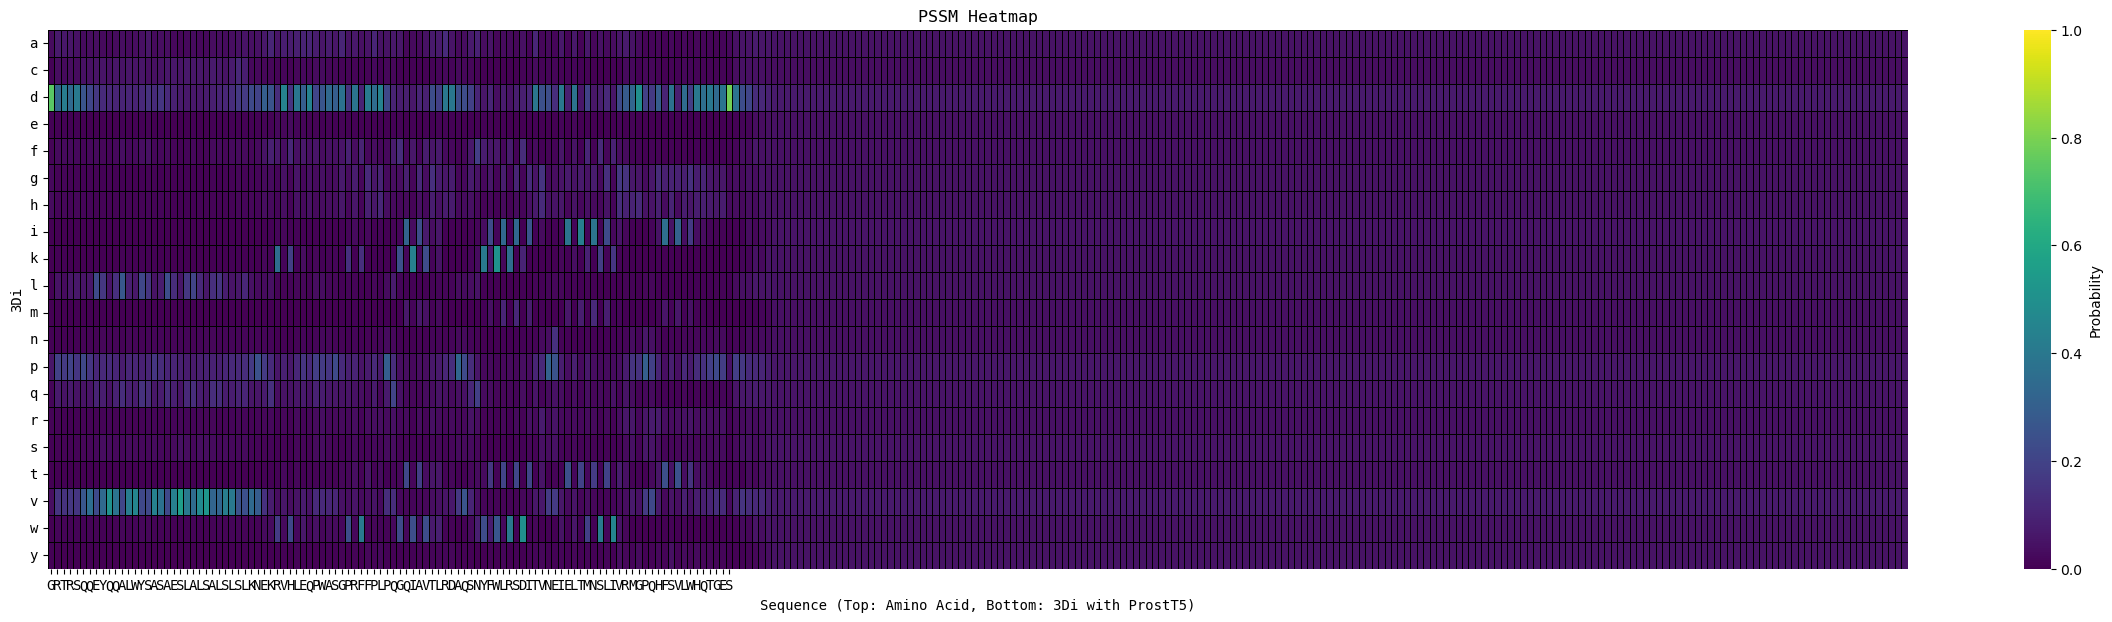

111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000
ELARASSQSTDLMEAMAMGSVEASYKCLAAALIVLTESGRSAHQVARYRPRAPIIAVTRNHQTARQAHLYRGIFPVVCKDPVQEAWAEDVDLRVNLAMNVGKARGFFKKGDVVIVLTGWRPGSGFTNTMRVVPVP



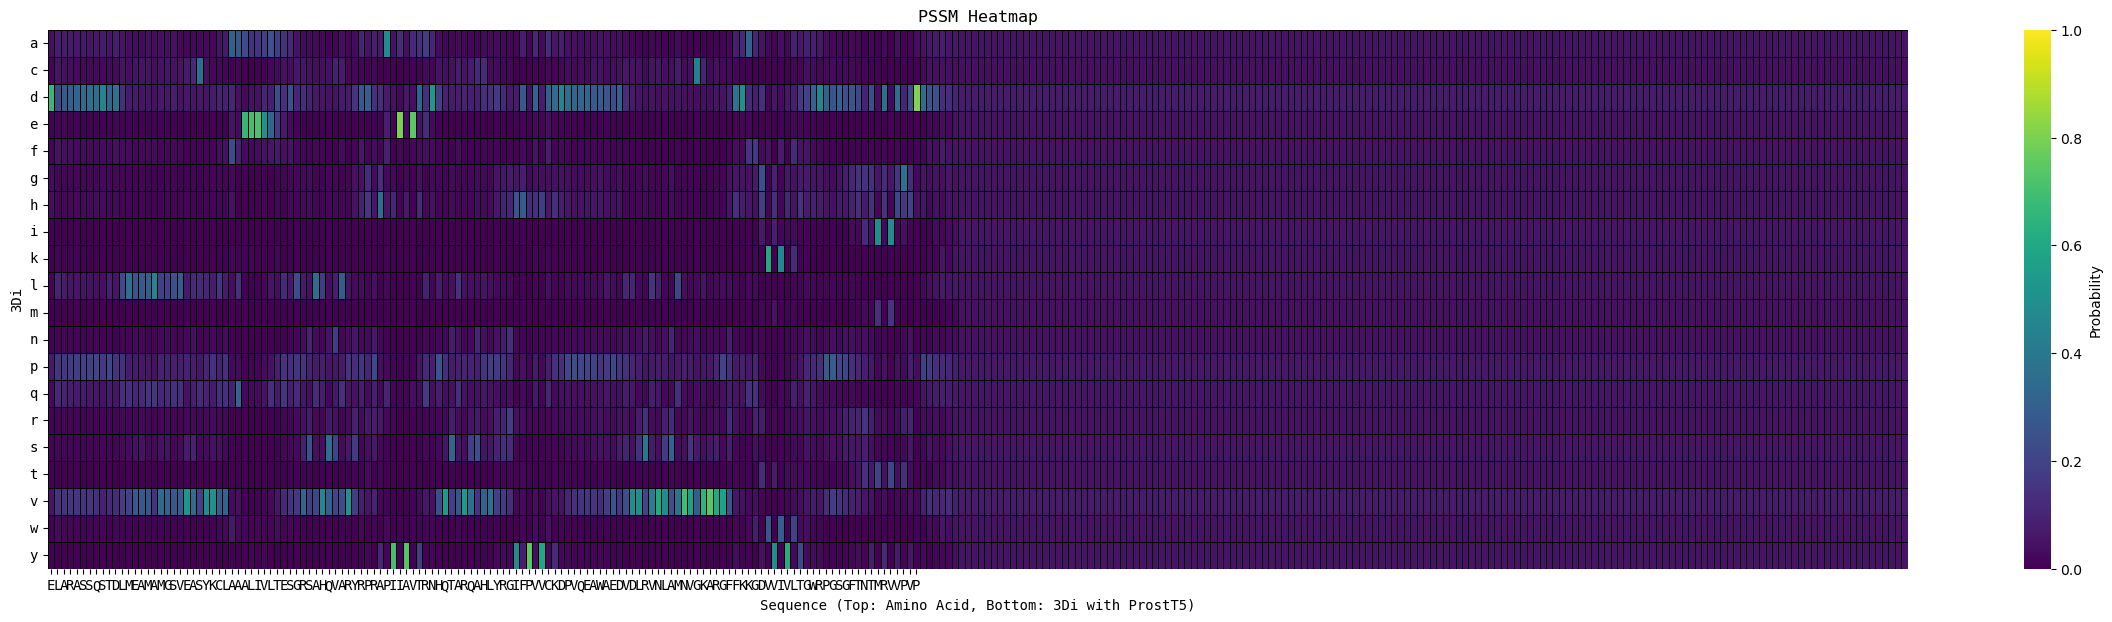

In [11]:
def plot_pssm(pssm, mask, original_sequence, prost_values=None):
    plt.figure(figsize=(30, 7))
    sns.heatmap(
        pssm.T,
        cmap="viridis",
        vmin=0,
        vmax=1,
        cbar_kws={"label": "Probability"},
        linewidths=0.5,
        linecolor="black",
    )
    plt.xticks(np.arange(len(original_sequence)) + 0.5, original_sequence, rotation=0, fontfamily="monospace")
    print()

    plt.yticks(np.arange(len(STRUCTURE_ALPHABET)) + 0.5, STRUCTURE_ALPHABET, rotation=0, fontfamily="monospace")

    plt.title("PSSM Heatmap", fontfamily="monospace")
    plt.xlabel("Sequence (Top: Amino Acid, Bottom: 3Di with ProstT5)", fontfamily="monospace")
    plt.ylabel("3Di", fontfamily="monospace")

    plt.show()


def run_batch(model, input_ids, attention_mask):
    model.eval()
    with torch.no_grad():
        print(*attention_mask[0].tolist(), sep="")
        print(*tokenizer.decode(input_ids[0], skip_special_tokens=True).replace(" ", ""), sep="")

        model_output = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=True,
        )

    for pssm, mask, ids in list(zip(model_output.pssms, model_output.masks, input_ids)):
        original_sequence = tokenizer.decode(ids, skip_special_tokens=True).replace(" ", "")
        print(*mask.tolist(), sep="")
        print(original_sequence)
        plot_pssm(pssm.cpu().numpy(), mask.cpu().numpy(), original_sequence)


run_batch(model, protein_tokens["input_ids"][:2], protein_tokens["attention_mask"][:2])

---


In [ ]:
tokenizer_prost = T5Tokenizer.from_pretrained("Rostlab/ProstT5", do_lower_case=False)
model_prost = AutoModelForSeq2SeqLM.from_pretrained("Rostlab/ProstT5").to(device)
model_prost.float() if device.type == "cpu" else model_prost.half()

sequence_examples = ["<AA2fold> " + s for s in sequences.values()]
ids = tokenizer_prost.batch_encode_plus(sequence_examples, add_special_tokens=True, padding="longest", return_tensors="pt").to(
    device
)

index = 0

print(len(list(sequences.values())[0]))
print(*[f"{x:<10}" for x in re.split("><| |</", tokenizer_prost.decode(ids["input_ids"][index]))])

print(*[f"{x:<10}" for x in ids["input_ids"][index].tolist()])
print(*[f"{x:<10}" for x in ids["attention_mask"][index].tolist()])

In [ ]:
gen_kwargs_aa2fold = {
    "do_sample": True,
    "num_beams": 3,
    "top_p": 0.95,
    "temperature": 1.2,
    "top_k": 6,
    "repetition_penalty": 1.2,
}

model_prost.eval()
with torch.no_grad():
    translations = model_prost.generate(
        ids.input_ids,
        attention_mask=ids.attention_mask,
        early_stopping=True,
        num_return_sequences=1,
        max_length=ids.input_ids.shape[1],
        **gen_kwargs_aa2fold,
    )
decoded_translations = tokenizer_prost.batch_decode(translations, skip_special_tokens=True)
structure_sequences = ["".join(ts.split(" ")) for ts in decoded_translations]


print(translations)
print(structure_sequences)
for x, y in zip(structure_sequences, sequences.values()):
    print(len(x), len(y.replace(" ", "")))

---


In [ ]:
import numpy as np
import pandas as pd

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

for i, ((k, v), (logits, mask)) in enumerate(zip(sequences.items(), zip(protein_emb.logits, protein_tokens["attention_mask"]))):
    # if i == 2:
    #     break

    df_pssms = pd.DataFrame(logits.cpu().numpy()[: mask.sum()])
    original_sequence = v.split()
    original_sequence = [f"{a}\n{b}" for a, b in zip(original_sequence, structure_sequences[i])]

    # fig = px.imshow(
    #     df_pssms.T,
    #     color_continuous_scale="viridis",
    #     range_color=[0, 1],
    #     title=f"PSSM Heatmap for {k}",
    #     labels={"x": "Sequence", "y": "Position"},
    # )

    # # Create labels combining original sequence and structure sequence
    # combined_labels = [f"{a}\n{b}" for a, b in zip(original_sequence, structure_sequences[i])]
    # fig.update_xaxes(ticktext=combined_labels, tickvals=list(range(len(original_sequence))))
    # fig.show()

    plt.figure(figsize=(30, 7))
    sns.heatmap(
        df_pssms.T,
        cmap="viridis",
        vmin=0,
        vmax=1,
        cbar_kws={"label": "Probability"},
        linewidths=0.5,
        linecolor="black",
    )
    plt.xticks(np.arange(len(original_sequence)) + 0.5, original_sequence, rotation=0, fontfamily="monospace")
    print()

    plt.yticks(np.arange(len(STRUCTURE_ALPHABET)) + 0.5, STRUCTURE_ALPHABET, rotation=0, fontfamily="monospace")

    plt.title("PSSM Heatmap", fontfamily="monospace")
    plt.xlabel("Sequence (Top: Amino Acid, Bottom: 3Di with ProstT5)", fontfamily="monospace")
    plt.ylabel("3Di", fontfamily="monospace")

    plt.show()


---